In [47]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

plt.style.use([
    'grid',
    'notebook'
])

In [48]:
Ts = .5

sim_time = 2500
iterations = int(sim_time / Ts)

time = np.arange(0, sim_time, Ts)

r = .31
mu = .40
sigma = .55
A2 = .3019

In [49]:
def M1(Z1):
    return 0.354358610914245*Z1 + 0.182849043231751

def N1(Z2):
    return 227.272727272727*Z2 - 0.75

def O1(Z3):
    return 0.0666258028409242*Z3 - 0.22971244303493

def M2(Z1):
    return 1-M1(Z1)

def N2(Z2):
    return 1-N1(Z2)

def O2(Z3):
    return 1-O1(Z3)

pertinence_functions = np.array([
    [M1, M2],
    [N1, N2],
    [O1, O2]
])

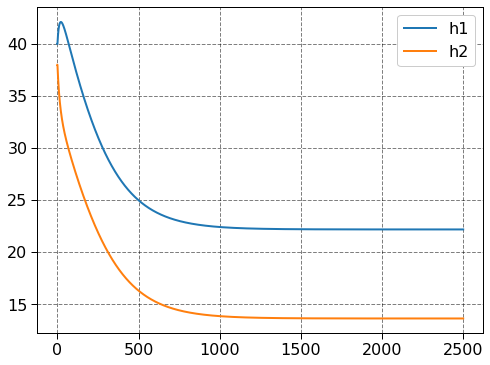

In [50]:
h1_t = np.zeros(iterations)
h2_t = np.zeros(iterations)

h1_0 = 40
h2_0 = 38

h1_t[0] = h1_0
h2_t[0] = h2_0

h1 = h1_0
h2 = h2_0

n = 8

A_matrices = [np.load(f'./vertices/A_{i}.npy') for i in range(n)]
B_matrices = [np.load(f'./vertices/B_{i}.npy') for i in range(n)]

u = 60

for i in range(1, iterations):
    diff = h1 - h2

    R12 = (0.2371*diff+6.9192)*10
    q0  = (18.6367*h2+700.6831)*1e-4
    a1 = (3*r/5)*(2.7*r-((np.cos(2.5*np.pi*(h1-8)*1e-2-mu))/(sigma*np.sqrt(2*np.pi)))*np.exp(-(((h1-8)*1e-2-mu)**2)/(2*sigma**2)))

    Z1 = 1/R12
    Z2 = q0/h2
    Z3 = 1/a1

    h1_t[i] = h1
    h2_t[i] = h2

    h = np.array([
        [h1],
        [h2]
    ])

    v = np.array([
        [pertinence_functions[0, 0](Z1), pertinence_functions[0, 1](Z1)],
        [pertinence_functions[1, 0](Z2), pertinence_functions[1, 1](Z2)],
        [pertinence_functions[2, 0](Z3), pertinence_functions[2, 1](Z3)],
    ])

    weights = np.array([
        v[0, 1] * v[1, 1] * v[2, 1],
        v[0, 1] * v[1, 1] * v[2, 0],
        v[0, 1] * v[1, 0] * v[2, 1],
        v[0, 1] * v[1, 0] * v[2, 0],
        v[0, 0] * v[1, 1] * v[2, 1],
        v[0, 0] * v[1, 1] * v[2, 0],
        v[0, 0] * v[1, 0] * v[2, 1],
        v[0, 0] * v[1, 0] * v[2, 0],
    ])

    Ai = sum([A_matrices[j] * weights[j] for j in range(n)])
    Bi = sum([B_matrices[j] * weights[j] for j in range(n)])

    delta_sys = (Ai @ h) + Bi * u
    sys = h + (delta_sys * Ts)

    h1 = sys[0, 0]
    h2 = sys[1, 0]

    
plt.plot(time, h1_t, label='h1')
plt.plot(time, h2_t, label='h2')
plt.legend()